<a href="https://colab.research.google.com/github/artms-18/ML-Projects/blob/main/StockPrediction_better.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## STOCK PREDICTION WITH TENSORFLOW 2.0!

In this notebook, we will be predicting prices of General Electric's stock using a Transformer neural network

## Step 1 - Import data

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import tensorflow as tf

print(tf.__version__)

2.4.1


In [8]:
uploaded = files.upload()


Saving GE (1).csv to GE (1) (1).csv


In [9]:
for fn in uploaded.keys():
  print("User uploaded file {name} with length {length} bytes".format(name = fn, length = len(uploaded[fn])))

User uploaded file GE (1).csv with length 884373 bytes


In [10]:
import io

df = pd.read_csv(io.StringIO(uploaded['GE (1).csv'].decode('utf-8')))

In [11]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1969-01-06,0.959034,0.959034,0.939002,0.945262,0.190349,2805504
1,1969-01-07,0.941506,0.941506,0.911458,0.925230,0.186315,4233216
2,1969-01-08,0.925230,0.930238,0.907702,0.921474,0.185559,3065088
3,1969-01-09,0.921474,0.931490,0.916466,0.920222,0.185306,3065088
4,1969-01-10,0.917718,0.917718,0.906450,0.906450,0.182533,2595840


In [12]:
# Sort Dataframe by date

df = df.sort_values('Date')

# Check result

df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,1969-01-06,0.959034,0.959034,0.939002,0.945262,0.190349,2805504
1,1969-01-07,0.941506,0.941506,0.911458,0.925230,0.186315,4233216
2,1969-01-08,0.925230,0.930238,0.907702,0.921474,0.185559,3065088
3,1969-01-09,0.921474,0.931490,0.916466,0.920222,0.185306,3065088
4,1969-01-10,0.917718,0.917718,0.906450,0.906450,0.182533,2595840


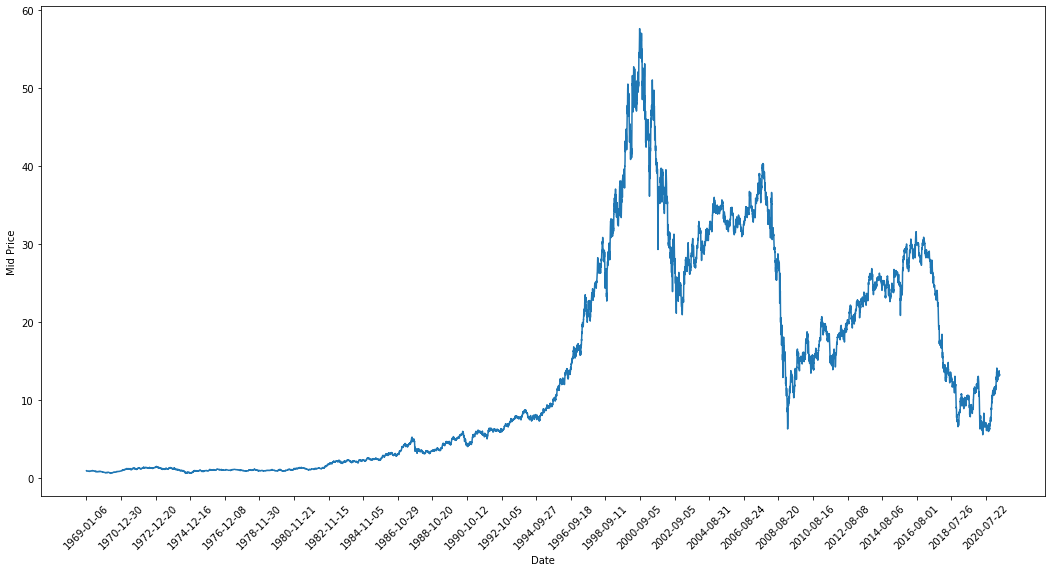

In [13]:
# Visualize data

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), (df['Low'] + df['High'])/2.0)
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation = 45)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Mid Price', fontsize = 10)
plt.show()

## Step 2 - Data preprocessing

In [14]:
df['mid'] = (df['Low'] + df['High'])/2.0

In [15]:
SEQ_LEN = 60 # how long of a preceeding sequence to collect for RNN

FUTURE_PERIOD_PREDICT = 1 # how far in the future are we trying to predict?

RATIO_TO_PREDICT = 'mid'

In [16]:
def classify(current, future):
  if float(future) > float(current):
    return 1
  else:
    return 0

In [17]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT) #shifts by 1

In [18]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [19]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,mid,future,target
0,1969-01-06,0.959034,0.959034,0.939002,0.945262,0.190349,2805504,0.949018,0.926482,0
1,1969-01-07,0.941506,0.941506,0.911458,0.925230,0.186315,4233216,0.926482,0.918970,0
2,1969-01-08,0.925230,0.930238,0.907702,0.921474,0.185559,3065088,0.918970,0.923978,1
3,1969-01-09,0.921474,0.931490,0.916466,0.920222,0.185306,3065088,0.923978,0.912084,0
4,1969-01-10,0.917718,0.917718,0.906450,0.906450,0.182533,2595840,0.912084,0.910832,0


In [20]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,mid,future,target
13193,2021-04-28,13.33,13.35,13.15,13.20,13.20,66095400,13.250,13.185,0
13194,2021-04-29,13.18,13.29,13.08,13.21,13.21,55157600,13.185,13.215,1
13195,2021-04-30,13.16,13.35,13.08,13.12,13.12,49863500,13.215,13.350,1
13196,2021-05-03,13.24,13.53,13.17,13.45,13.45,63472500,13.350,13.230,0
13197,2021-05-04,13.34,13.39,13.07,13.12,13.12,77489600,13.230,NaN,0


In [21]:
times = sorted(df.index.values) # get the times

last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]
train_df = df[(df.index < last_20pct)] # now the train_df is all the data up to the last 20%

In [22]:
from collections import deque
import numpy as np
import random

In [23]:
train_df.drop(columns = ['Date', 'future', 'Open', 'High', 'Low', 'Close', 'Volume'], inplace = True)
validation_df.drop(columns = ['Date', 'future', 'Open', 'High', 'Low', 'Close', 'Volume'], inplace = True)
test_df.drop(columns = ['Date', 'future', 'Open', 'High', 'Low', 'Close','Volume'], inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
train_df.head()

,Adj Close,mid,target
0,0.190349,0.949018,0
1,0.186315,0.926482,0
2,0.185559,0.918970,1
3,0.185306,0.923978,0
4,0.182533,0.912084,0


In [25]:
# putting data into an array format

train_data = train_df[RATIO_TO_PREDICT].to_numpy()
valid_data = validation_df[RATIO_TO_PREDICT].to_numpy()
test_data  = test_df[RATIO_TO_PREDICT].to_numpy()

In [26]:
# reshaping data

train_data = train_data.reshape(-1,1) # flattens data along y axis
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [27]:
scaler = MinMaxScaler()

In [28]:
# Train the scaler with training data and smooth data

smoothing_window_size = 2500

for di in range(0, 10000, smoothing_window_size):
  scaler.fit(train_data[di: di + smoothing_window_size,:])
  train_data[di: di+smoothing_window_size:,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# Normalize the last bit of remaining data

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di + smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [29]:
# Reshape both train and test data

train_data = train_data.reshape(-1)

# Normalize test data and validation data

valid_data = scaler.transform(valid_data).reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)



In [30]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data

EMA = 0.0
gamma = 0.1

for ti in range(10559):
  EMA = gamma*train_data[ti] + (1-gamma) * EMA #uses previous data to smooth
  train_data[ti] = EMA

# Used for visualization and test purposes

all_mid_data = np.concatenate([train_data, valid_data, test_data], axis = 0)


In [31]:
#batching data

X_train = []
y_train = []

for i in range(SEQ_LEN, len(train_data)):
  X_train.append(train_data[i-SEQ_LEN:i])
  y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [32]:
X_valid = []
y_valid = []

for i in range(SEQ_LEN, len(valid_data)):
  X_valid.append(valid_data[i-SEQ_LEN:i])
  y_valid.append(valid_data[i+(FUTURE_PERIOD_PREDICT - 1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [33]:
X_test = []
y_test = []

for i in range(SEQ_LEN, len(test_data)):
  X_test.append(test_data[i-SEQ_LEN:i])
  y_test.append(test_data[i + (FUTURE_PERIOD_PREDICT) - 1])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [34]:
X_train_2 = []
y_train_2 = []

for i in range(SEQ_LEN, len(train_data)):
  X_train_2.append(train_data[i-SEQ_LEN:i])
  y_train_2.append(train_data[i + (FUTURE_PERIOD_PREDICT) - 1])

X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))



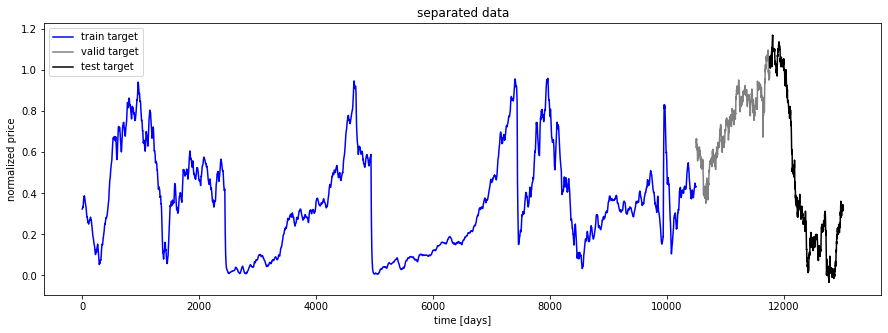

In [35]:
# looking at preprocessed data

plt.figure(figsize = (15, 5))
plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color = 'blue', label = 'train target')
plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid, color = 'gray', label = 'valid target')
plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0], y_train_2.shape[0]+ y_valid.shape[0]+y_test.shape[0]), y_test, color = 'black', label = 'test target')

plt.title("separated data")
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc = 'best')


In [36]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [37]:
EPOCHS = 10
BATCH_SIZE = 1024
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

In [38]:
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
import tensorflow as tf
from tensorflow.keras.initializers import *
from tensorflow.python.keras.layers import Layer

try:
  from dataloader import TokenList, pad_to_longest
except: pass



from keras import backend as K

In [39]:
embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [40]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 1))
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error", 
        #optimizer = Adam(lr = config["lr"], decay = config["lr_d"]), 
        optimizer = "adam")
    
    # Save entire model to a HDF5 file
    #model.save('my_model.h5')
    
    return model

multi_head = build_model()

In [43]:
multi_head.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 60, 256)      133120      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 128)      164352      bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 60, 192)      24576       bidirectional_1[0][0]            
______________________________________________________________________________________________

In [44]:
multi_head.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_valid, y_valid))

Epoch 1/10
11/11 [==============================] - 77s 6s/step - loss: 0.1515 - val_loss: 0.2424
Epoch 2/10
11/11 [==============================] - 65s 6s/step - loss: 0.0725 - val_loss: 0.0369
Epoch 3/10
11/11 [==============================] - 65s 6s/step - loss: 0.0194 - val_loss: 0.0415
Epoch 4/10
11/11 [==============================] - 66s 6s/step - loss: 0.0086 - val_loss: 0.0224
Epoch 5/10
11/11 [==============================] - 65s 6s/step - loss: 0.0082 - val_loss: 0.0359
Epoch 6/10
11/11 [==============================] - 64s 6s/step - loss: 0.0062 - val_loss: 0.0286
Epoch 7/10
11/11 [==============================] - 64s 6s/step - loss: 0.0058 - val_loss: 0.0290
Epoch 8/10
11/11 [==============================] - 64s 6s/step - loss: 0.0050 - val_loss: 0.0279
Epoch 9/10
11/11 [==============================] - 63s 6s/step - loss: 0.0051 - val_loss: 0.0316
Epoch 10/10
11/11 [==============================] - 63s 6s/step - loss: 0.0048 - val_loss: 0.0281


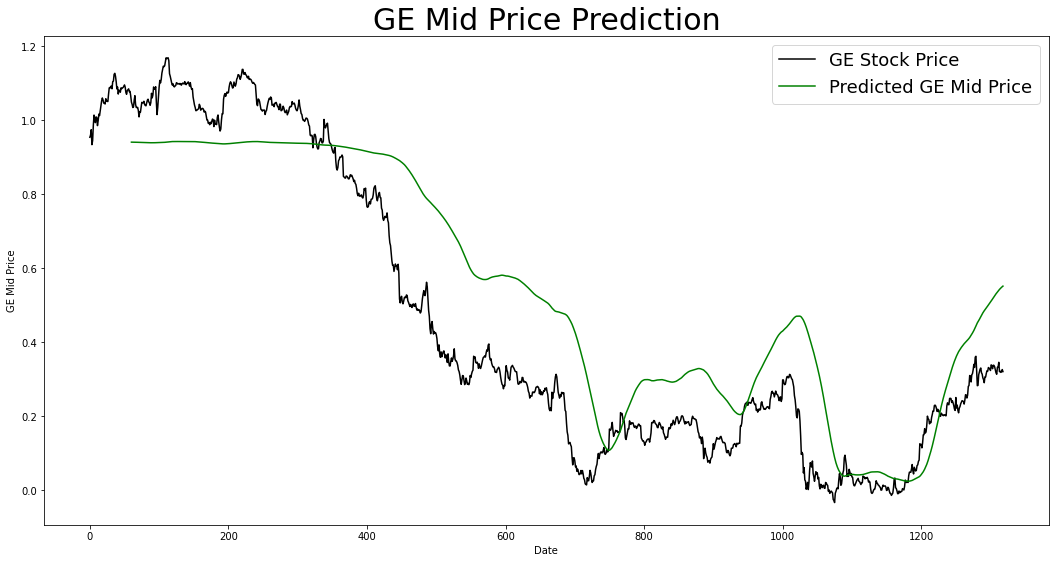

In [46]:
predicted_stock_price_multi_head = multi_head.predict(X_test)
#predicted_stock_price_multi_head.shape()

predicted_stock_price_multi_head = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))

plt.figure(figsize = (18,9))
plt.plot(test_data, color= 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_multi_head, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize = 30)
plt.xlabel('Date')
plt.ylabel('GE Mid Price')
plt.legend(fontsize = 18)
plt.show()

